In [93]:
import numpy as np
import matplotlib.pyplot as plt

In [94]:
class Maze:
    def __init__(self):
        self.maze = np.zeros((6, 9))
        obstacle = [(0, 7), (1, 7), (2, 7), (1, 2), (2, 2), (3, 2), (4, 5)]
        self.maze[*tuple(zip(*obstacle))] = 1

        self.start = (2, 0)
        self.goal = (0, 8)

    def reset(self):
        self.state = self.start
        return self.state
    
    def step(self, action):
        action_table = {0: (-1, 0), 1: (0, 1), 2: (1, 0), 3: (0, -1)}
        next_state = self.state + np.array(action_table[action])
        next_state = tuple(next_state)

        if next_state[0] < 0 or next_state[0] >= 6 or next_state[1] < 0 or next_state[1] >= 9:
            next_state = self.state

        if self.maze[next_state] == 1:
            next_state = self.state

        self.state = next_state
        reward = 0
        done = False

        if next_state == self.goal:
            reward = 1
            done = True

        return next_state, reward, done

In [95]:
class DynaQ:
    def __init__(self, n, do=False):
        self.gamma = 0.95
        self.alpha = 0.1
        self.epsilon = 0.1

        self.n = n
        self.Q = np.zeros((6, 9, 4))

        if do:
            self.do()

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        else:
            max_index = np.where(self.Q[state] == np.max(self.Q[state]))[0]
            return np.random.choice(max_index)
        
    def update(self, state, action, reward, next_state, done):
        if done:
            self.Q[state][action] += self.alpha * (reward - self.Q[state][action])
        else:
            self.Q[state][action] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])
    
    def do(self):
        episodes = 50

        env = Maze()
        model = []

        self.steps = []

        for episode in range(episodes):
            state = env.reset()

            for i in range(10000):
                action = self.choose_action(state)
                next_state, reward, done = env.step(action)

                m = (state, action, reward, next_state, done)
                if not m in model:
                    model.append((state, action, reward, next_state, done))

                self.update(state, action, reward, next_state, done)

                for _ in range(self.n):
                    idx = np.random.randint(len(model))
                    state_, action_, reward_, next_state_, done_ = model[idx]
                    self.update(state_, action_, reward_, next_state_, done_)
                    
                state = next_state
                if done:
                    break
            
            self.steps.append(i)

In [136]:
class n_SARSA:
    def __init__(self, n, do=False):
        self.gamma = 0.95
        self.alpha = 0.1
        self.epsilon = 0.1
        
        self.n = n
        self.Q = np.zeros((6, 9, 4))

        if do:
            self.do()

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(4)
        else:
            max_index = np.where(self.Q[state] == np.max(self.Q[state]))[0]
            return np.random.choice(max_index)
    
    def do(self):
        env = Maze()
        episodes = 50

        self.steps = []

        for episode in range(episodes):
            SA_s = []
            rewards = []
            state = env.reset()
            action = self.choose_action(state)
            SA_s.append((*state, action))

            t = 0
            T = 100000
            for i in range(10000):
                if t < T:
                    state, reward, done = env.step(action)
                    rewards.append(reward)
                    if done:
                        T = t + 1
                    else:
                        action = self.choose_action(state)
                        SA_s.append((*state, action))
                        # print(t, state, action)
                        # time.sleep(0.0001)
                tau = t - self.n + 1
                if tau >= 0:
                    G = sum([self.gamma ** (i-tau) * rewards[i] for i in range(tau, min(tau+self.n, T))])
                    if tau + self.n < T:
                        G += self.gamma ** self.n * self.Q[SA_s[tau+self.n]]
                    self.Q[SA_s[tau]] += self.alpha * (G - self.Q[SA_s[tau]])
                if tau == T - 1:
                    break
                t += 1

            self.steps.append(i)
                

In [137]:
SARSA_4 = [n_SARSA(4, do=True) for _ in range(30)]
dynaQ_0 = [DynaQ(0, do=True) for _ in range(30)]
dynaQ_5 = [DynaQ(5, do=True) for _ in range(30)]
dynaQ_50 = [DynaQ(50, do=True) for _ in range(30)]

steps_SARSA = np.array([sarsa.steps for sarsa in SARSA_4])
steps_0 = np.array([dynaQ.steps for dynaQ in dynaQ_0])
steps_5 = np.array([dynaQ.steps for dynaQ in dynaQ_5])
steps_50 = np.array([dynaQ.steps for dynaQ in dynaQ_50])

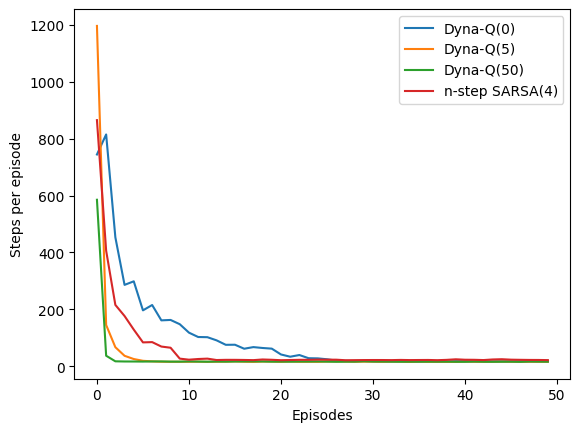

In [138]:
plt.plot(steps_0.mean(axis=0), label='Dyna-Q(0)')
plt.plot(steps_5.mean(axis=0), label='Dyna-Q(5)')
plt.plot(steps_50.mean(axis=0), label='Dyna-Q(50)')
plt.plot(steps_SARSA.mean(axis=0), label='n-step SARSA(4)')

plt.xlabel('Episodes')
plt.ylabel('Steps per episode')
# plt.ylim(10, 300)
plt.legend()
plt.show()